In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/CarloSgaravatti/Recsys_Challenge_2023.git

Cloning into 'Recsys_Challenge_2023'...
remote: Enumerating objects: 239, done.
remote: Counting objects: 100% (239/239), done.
remote: Compressing objects: 100% (201/201), done.
remote: Total 239 (delta 73), reused 170 (delta 32), pack-reused 0
Receiving objects: 100% (239/239), 11.22 MiB | 22.04 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
!pip install PyGithub requests

  Obtaining dependency information for PyGithub from https://files.pythonhosted.org/packages/be/04/810d131be173cba445d3658a45512b2b2b3d0960d52c4a300d6ec5e00f52/PyGithub-2.1.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 23.5 MB/s eta 0:00:00


In [3]:
! cd /kaggle/working/Recsys_Challenge_2023 && python run_compile_all_cython.py

run_compile_all_cython: Found 10 Cython files in 4 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/opt/conda/bin/python'
Compiling [1/10]: MatrixFactorizationImpressions_Cython_Epoch.pyx... 
In file included from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from MatrixFactorizationImpressions_Cython_Epoch.c:1109:
/opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
MatrixFactorizationImpressions_Cython_Epoch.c: In functio

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import random
import tqdm
import gc
import time
import os
import shutil
import optuna
import scipy.sparse as sps

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv
/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv
/kaggle/input/hyperparameters-tuning/__results__.html
/kaggle/input/hyperparameters-tuning/tuning.db
/kaggle/input/hyperparameters-tuning/__notebook__.ipynb
/kaggle/input/hyperparameters-tuning/__output__.json
/kaggle/input/hyperparameters-tuning/best_params_ials.json
/kaggle/input/hyperparameters-tuning/custom.css
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/run_all_algorithms.py
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/cython_example_FunkSVD.py
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/LICENSE
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/.gitignore
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/README.md
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/run_hyperparameter_search.py
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/cython_examp

# Configurations

In [5]:
from github import Github
from github import Auth

auth = Auth.Token(token)
g = Github(auth=auth)

repo = None
for r in g.get_user().get_repos():
    if r.name == 'Recsys_Challenge_2023':
        repo = r
        print('Repository found')

Repository found


In [6]:
def upload_file(filepath_kaggle, filepath_github, commit_message):
    try:
        contents = repo.get_contents(filepath_github)
        with open(filepath_kaggle, "rb") as file:
            repo.update_file(contents.path, commit_message, file.read(), contents.sha)
    except Exception:
        with open(filepath_kaggle, "rb") as file:
            repo.create_file(filepath_github, commit_message, file.read())

In [7]:
from os import system, getpid, walk
from psutil import Process
from colorama import Fore, Style, init
from IPython.display import display, HTML

def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    print(style + color + text + Style.RESET_ALL)
    
def GetMemUsage():   
    pid = getpid()
    py = Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return f"RAM memory GB usage = {memory_use :.4}"

PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 0.2155


In [8]:
config = {
    'tune_parameters_item_knn': False,
    'tune_parameters_user_knn': False,
    'tune_parameters_pure_svd': False,
    'tune_parameters_ials': True,
    'database_path': '/kaggle/working/tuning.db',
    'copy_prev_tuning_db': True,
    'copy_prev_best_params': False,
    'train_best_models': False,
    'copy_prev_best_models': False,
    'submit': False,
    'save_github': True
}

In [9]:
try:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/tuning_results/tuning.db', 
        config['database_path']
    )
except FileNotFoundError:
    pass # if not present optuna will create it

# Data Import

In [10]:
train_data = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv')
user_ids_test = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv')

In [11]:
train_data.head(5)

,row,col,data
0,1,7,1.0
1,1,15,1.0
2,1,16,1.0
3,1,133,1.0
4,1,161,1.0


In [12]:
user_ids_test.head(5)

,user_id
0,1
1,2
2,3
3,4
4,5


In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478730 entries, 0 to 478729
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   row     478730 non-null  int64  
 1   col     478730 non-null  int64  
 2   data    478730 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 11.0 MB


In [14]:
train_data.describe()

,row,col,data
count,478730.000000,478730.000000,478730.0
mean,6477.521302,4101.952798,1.0
std,3738.435208,5388.639634,0.0
min,1.000000,1.000000,1.0
25%,3204.000000,315.000000,1.0
50%,6493.000000,1575.000000,1.0
75%,9715.000000,5879.000000,1.0
max,13024.000000,22347.000000,1.0


In [15]:
n_users_train = train_data.row.max()
n_users_test = len(user_ids_test.user_id.unique())

print(f'Train number of users: {n_users_train}')
print(f'Test number of users: {n_users_test}')

Train number of users: 13024
Test number of users: 10882


In [16]:
number_of_items = train_data.col.max()

print(f'Number of items: {number_of_items}')

Number of items: 22347


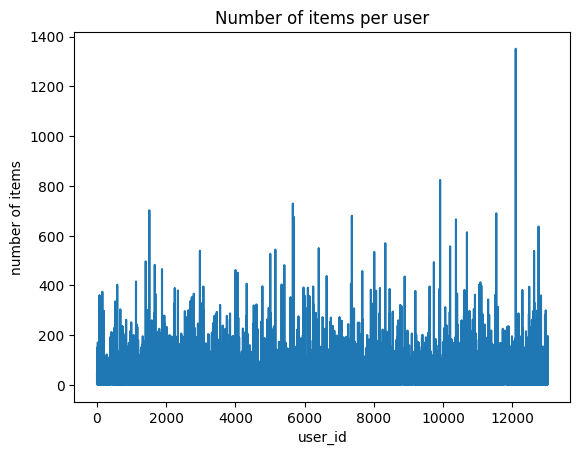

In [17]:
train_data.groupby('row').count().col.plot()
plt.xlabel('user_id')
plt.ylabel('number of items')
plt.title('Number of items per user');

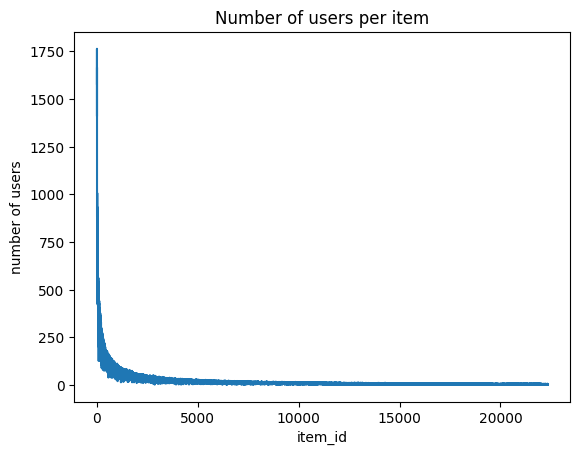

In [18]:
train_data.groupby('col').count().row.plot()
plt.xlabel('item_id')
plt.ylabel('number of users')
plt.title('Number of users per item');

In [19]:
URM_all = sps.csr_matrix((train_data.data.values,
                          ((train_data.row - 1).values, (train_data.col - 1).values)),
                        shape=(train_data.row.max(), train_data.col.max()))
URM_all

<13024x22347 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

# Cross Validation Split

In [20]:
%cd /kaggle/working/Recsys_Challenge_2023

/kaggle/working/Recsys_Challenge_2023


In [21]:
from Data_manager.IncrementalSparseMatrix import IncrementalSparseMatrix


class CrossValidationSplitter:
    def __init__(self, n_splits):
        self.n_splits = n_splits
        self.folds = []
        
    def split(self, URM):
        n_int_per_split = int(URM.nnz / self.n_splits)
        indices = np.arange(0, URM.nnz, 1)
        np.random.shuffle(indices)
        num_users, num_items = URM.shape
        
        URM_all = sps.coo_matrix(URM)
        
        for i in range(self.n_splits):
            if i == self.n_splits - 1:
                indices_valid = indices[n_int_per_split * i:]
                indices_train = indices[:n_int_per_split * i]
            else:
                indices_valid = indices[n_int_per_split * i: n_int_per_split * (i + 1)]
                indices_train_1 = indices[n_int_per_split * max(0, i - 1): n_int_per_split * i]
                indices_train_2 = indices[n_int_per_split * (i + 1):]
                indices_train = np.concatenate((indices_train_1, indices_train_2))
                
            URM_valid_builder = IncrementalSparseMatrix(
                n_rows=num_users, n_cols=num_items, auto_create_col_mapper=False, 
                auto_create_row_mapper=False
            )
            
            URM_train_builder = IncrementalSparseMatrix(
                n_rows=num_users, n_cols=num_items, auto_create_col_mapper=False, 
                auto_create_row_mapper=False
            )
            
            URM_valid_builder.add_data_lists(
                URM_all.row[indices_valid],
                URM_all.col[indices_valid],
                URM_all.data[indices_valid]
            )
            
            URM_train_builder.add_data_lists(
                URM_all.row[indices_train],
                URM_all.col[indices_train],
                URM_all.data[indices_train]
            )
            
            yield URM_train_builder.get_SparseMatrix(), URM_valid_builder.get_SparseMatrix()

# Experiments

In [22]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

In [23]:
URM_train, URM_test_complete = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_validation, URM_test = split_train_in_two_percentage_global_sample(URM_test_complete, train_percentage = 0.8)

In [24]:
# recommender = MultiThreadSLIM_SLIMElasticNetRecommender(URM_train)
# recommender.fit(l1_ratio=0.5, alpha=1, positive_only=True, topK=10)

# np.bool = bool
# np.float = float
# evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
# result_df, _ = evaluator.evaluateRecommender(recommender)
# result_df

In [25]:
# evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
# early_stopping_params = {
#     'epochs_min': 30,
#     'stop_on_validation': True,
#     'validation_every_n': 1,
#     'validation_metric': 'MAP',
#     'lower_validations_allowed': 5,
#     'evaluator_object': evaluator_validation
# }

# recommender = IALSRecommender(URM_train)
# recommender.fit(reg=1e-2, **early_stopping_params)

In [26]:
# evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])
# result_df, _ = evaluator.evaluateRecommender(recommender)
# result_df

In [27]:
# recommender = PureSVDRecommender(URM_train)
# recommender.fit(num_factors=100)

# evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
# result_df, _ = evaluator.evaluateRecommender(recommender)
# result_df

In [28]:
# recommender = ItemKNNCFRecommender(URM_train)
# recommender.fit(topK=10, shrink=100)

# evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
# result_df, _ = evaluator.evaluateRecommender(recommender)
# result_df

In [29]:
# recommender = UserKNNCFRecommender(URM_train)
# recommender.fit(topK=20, shrink=10)

# evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
# result_df, _ = evaluator.evaluateRecommender(recommender)
# result_df

# Hyperparameters tuning

Not considering adjusted cosine and pearson since they remove the mean of the interactions, but here there are all interactions equal to 1

## Item KNN Collaborative Filtering

In [30]:
def objective_item_knn(trial):
    similarity = trial.suggest_categorical('similarity', ["cosine", "asymmetric", "dice", "jaccard", "tanimoto", "tversky"])
    topK = trial.suggest_int('topK', 10, 1000)
    shrink = trial.suggest_int('shrink', 0, 500)
    
    map_sum = 0
    for URM_train, URM_valid in CrossValidationSplitter(10).split(URM_all):
        recommender = ItemKNNCFRecommender(URM_train)
        recommender.fit(topK=topK, shrink=shrink, similarity=similarity)

        evaluator = EvaluatorHoldout(URM_valid, cutoff_list=[10])
        result_df, _ = evaluator.evaluateRecommender(recommender)
        print(f'MAP is {result_df.loc[10, "MAP"]}')
        map_sum += result_df.loc[10, 'MAP']
        
    return map_sum / 10

In [31]:
%%time

if config['tune_parameters_item_knn']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_knn_item', 
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_item_knn, n_trials=75)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 10 µs


In [32]:
if config['tune_parameters_item_knn']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [33]:
if config['tune_parameters_item_knn']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [34]:
if config['tune_parameters_item_knn']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [35]:
if config['tune_parameters_item_knn']:
    with open('/kaggle/working/best_params_knn_item.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_knn_item.json', 
            'tuning_results/best_params_knn_item.json', 
            'Item KNN tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning/best_params_knn_item.json', 
        '/kaggle/working/best_params_knn_item.json'
    )

## User KNN Collaborative Filtering

In [36]:
def objective_user_knn(trial):
    similarity = trial.suggest_categorical('similarity', ["cosine", "asymmetric", "dice", "jaccard", "tanimoto", "tversky"])
    topK = trial.suggest_int('topK', 10, 1000)
    shrink = trial.suggest_int('shrink', 0, 500)
    
    map_sum = 0
    for URM_train, URM_valid in CrossValidationSplitter(10).split(URM_all):
        recommender = UserKNNCFRecommender(URM_train)
        recommender.fit(topK=topK, shrink=shrink, similarity=similarity)

        evaluator = EvaluatorHoldout(URM_valid, cutoff_list=[10])
        result_df, _ = evaluator.evaluateRecommender(recommender)
        map_sum += result_df.loc[10, 'MAP']
    return map_sum / 10

In [37]:
%%time

if config['tune_parameters_user_knn']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_knn_user',
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_user_knn, n_trials=75)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 9.54 µs


In [38]:
if config['tune_parameters_user_knn']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [39]:
if config['tune_parameters_user_knn']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [40]:
if config['tune_parameters_user_knn']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [41]:
if config['tune_parameters_user_knn']:
    with open('/kaggle/working/best_params_knn_user.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_knn_user.json', 
            'tuning_results/best_params_knn_user.json', 
            'User KNN tuning results (from kaggle notebook)'
        )
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning/best_params_knn_user.json', 
        '/kaggle/working/best_params_knn_user.json'
    )

## PureSVD

In [42]:
%%time

if config['tune_parameters_pure_svd']:
    n_factors = np.arange(5, 501, 5)
    map_results = []

    for i, factors in enumerate(n_factors):
        
        map_sum = 0
        for URM_train, URM_valid in CrossValidationSplitter(10).split(URM_all):
            recommender = PureSVDRecommender(URM_train)
            recommender.fit(num_factors=factors)

            evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
            result_df, _ = evaluator.evaluateRecommender(recommender)
            map_sum += result_df.loc[10, 'MAP']
        map_results.append(map_sum / 10)
        PrintColor(f'End trial {i}, with factors = {factors}: MAP is {result_df.loc[10, "MAP"]}')

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.78 µs


In [43]:
# sorted_indices = np.argsort(n_factors)
if config['tune_parameters_pure_svd']:
    plt.plot(n_factors, np.array(map_results))
    plt.xlabel('Factors')
    plt.ylabel('MAP')
    plt.title('Pure SVD Recommender');

In [44]:
if config['tune_parameters_pure_svd']:
    params = {'factors': int(n_factors[np.argsort(map_results)[-1]])}

    with open('/kaggle/working/pure_svd_params.json', 'w') as params_file:
        json.dump(params, params_file)
        
    trials = pd.DataFrame({'factor': n_factors, 'MAP': np.array(map_results)})
    trials.to_csv('/kaggle/working/pure_svd_trials.csv', index=False)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/pure_svd_params.json', 
            'tuning_results/pure_svd_params.json', 
            'Pure SVD tuning best params (from kaggle notebook)'
        )
        
        upload_file(
            '/kaggle/working/pure_svd_params.json', 
            'tuning_results/pure_svd_params.json', 
            'Pure SVD tuning trial results (from kaggle notebook)'
        )
        
elif config['copy_prev_best_params']:
    try:
        shutil.copyfile(
            '/kaggle/input/hyperparameters-tuning/pure_svd_params.json', 
            '/kaggle/working/pure_svd_params.json'
        )
    except FileNotFoundError:
        pass # not already tuned

# Alternating Least Squares

In [45]:
def objective_ials(trial):
    reg = trial.suggest_float('reg', 1e-5, 0.1, log=True)
    alpha = trial.suggest_float('alpha', 0.1, 1)
    num_factors = trial.suggest_int('num_factors', 10, 100)
    
    map_sum = 0
    for URM_train, URM_valid in CrossValidationSplitter(10).split(URM_all):
        evaluator_validation = EvaluatorHoldout(URM_valid, cutoff_list=[10])
        early_stopping_params = {
            'epochs_min': 1,
            'stop_on_validation': True,
            'validation_every_n': 1,
            'validation_metric': 'MAP',
            'lower_validations_allowed': 3,
            'evaluator_object': evaluator_validation
        }

        recommender = IALSRecommender(URM_train)
        recommender.fit(reg=reg, alpha=alpha, num_factors=num_factors, **early_stopping_params)

        evaluator = EvaluatorHoldout(URM_valid, cutoff_list=[10])
        result_df, _ = evaluator.evaluateRecommender(recommender)
        map_sum += result_df.loc[10, 'MAP']
    return map_sum / 10

In [46]:
%%time

if config['tune_parameters_ials']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_ials',
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_ials, n_trials=10)

[I 2023-11-19 15:43:48,734] Using an existing study with name 'hyperparameters_tuning_ials' instead of creating a new one.


EvaluatorHoldout: Ignoring 4043 (31.0%) Users that have less than 1 test interactions
IALSRecommender: URM Detected 500 ( 3.8%) users with no interactions.
IALSRecommender: URM Detected 172 ( 0.8%) items with no interactions.
IALSRecommender: Validation begins...
EvaluatorHoldout: Processed 8981 (100.0%) in 9.38 sec. Users per second: 958
IALSRecommender: CUTOFF: 10 - PRECISION: 0.0159782, PRECISION_RECALL_MIN_DEN: 0.0415073, RECALL: 0.0396567, MAP: 0.0060717, MAP_MIN_DEN: 0.0161447, MRR: 0.0535468, NDCG: 0.0309715, F1: 0.0227786, HIT_RATE: 0.1398508, ARHR_ALL_HITS: 0.0569527, NOVELTY: 0.0042877, AVERAGE_POPULARITY: 0.4163015, DIVERSITY_MEAN_INTER_LIST: 0.8935355, DIVERSITY_HERFINDAHL: 0.9893436, COVERAGE_ITEM: 0.0223744, COVERAGE_ITEM_HIT: 0.0082338, ITEMS_IN_GT: 0.6097910, COVERAGE_USER: 0.6895731, COVERAGE_USER_HIT: 0.0964373, USERS_IN_GT: 0.6895731, DIVERSITY_GINI: 0.0048623, SHANNON_ENTROPY: 7.1666354, RATIO_DIVERSITY_HERFINDAHL: 0.9897012, RATIO_DIVERSITY_GINI: 0.0139497, RATIO_S

[I 2023-11-19 16:10:33,409] Trial 10 finished with value: 0.006433616746314476 and parameters: {'reg': 0.01414673132957959, 'alpha': 0.9602857892454195, 'num_factors': 73}. Best is trial 0 with value: 0.013600904088807968.


EvaluatorHoldout: Ignoring 4049 (31.1%) Users that have less than 1 test interactions
IALSRecommender: URM Detected 502 ( 3.9%) users with no interactions.
IALSRecommender: URM Detected 182 ( 0.8%) items with no interactions.
IALSRecommender: Validation begins...
EvaluatorHoldout: Processed 8975 (100.0%) in 8.05 sec. Users per second: 1115
IALSRecommender: CUTOFF: 10 - PRECISION: 0.0131253, PRECISION_RECALL_MIN_DEN: 0.0329985, RECALL: 0.0312804, MAP: 0.0047568, MAP_MIN_DEN: 0.0116788, MRR: 0.0427291, NDCG: 0.0239460, F1: 0.0184916, HIT_RATE: 0.1175487, ARHR_ALL_HITS: 0.0450776, NOVELTY: 0.0042143, AVERAGE_POPULARITY: 0.4303977, DIVERSITY_MEAN_INTER_LIST: 0.8739911, DIVERSITY_HERFINDAHL: 0.9873894, COVERAGE_ITEM: 0.0528483, COVERAGE_ITEM_HIT: 0.0065781, ITEMS_IN_GT: 0.6119837, COVERAGE_USER: 0.6891124, COVERAGE_USER_HIT: 0.0810043, USERS_IN_GT: 0.6891124, DIVERSITY_GINI: 0.0057448, SHANNON_ENTROPY: 7.2201646, RATIO_DIVERSITY_HERFINDAHL: 0.9877463, RATIO_DIVERSITY_GINI: 0.0164826, RATIO_

[I 2023-11-19 16:46:35,895] Trial 11 finished with value: 0.012291461757685012 and parameters: {'reg': 0.0022826596367394344, 'alpha': 0.9680321129386334, 'num_factors': 20}. Best is trial 0 with value: 0.013600904088807968.


EvaluatorHoldout: Ignoring 4001 (30.7%) Users that have less than 1 test interactions
IALSRecommender: URM Detected 489 ( 3.8%) users with no interactions.
IALSRecommender: URM Detected 176 ( 0.8%) items with no interactions.
IALSRecommender: Validation begins...
EvaluatorHoldout: Processed 9023 (100.0%) in 8.85 sec. Users per second: 1020
IALSRecommender: CUTOFF: 10 - PRECISION: 0.0147290, PRECISION_RECALL_MIN_DEN: 0.0378177, RECALL: 0.0359404, MAP: 0.0055644, MAP_MIN_DEN: 0.0142180, MRR: 0.0490264, NDCG: 0.0279357, F1: 0.0208949, HIT_RATE: 0.1294470, ARHR_ALL_HITS: 0.0521658, NOVELTY: 0.0041973, AVERAGE_POPULARITY: 0.4597492, DIVERSITY_MEAN_INTER_LIST: 0.8575010, DIVERSITY_HERFINDAHL: 0.9857406, COVERAGE_ITEM: 0.0205397, COVERAGE_ITEM_HIT: 0.0061306, ITEMS_IN_GT: 0.6094778, COVERAGE_USER: 0.6927979, COVERAGE_USER_HIT: 0.0896806, USERS_IN_GT: 0.6927979, DIVERSITY_GINI: 0.0036489, SHANNON_ENTROPY: 6.7440752, RATIO_DIVERSITY_HERFINDAHL: 0.9860967, RATIO_DIVERSITY_GINI: 0.0104627, RATIO_

[I 2023-11-19 17:40:17,910] Trial 12 finished with value: 0.013339070159714621 and parameters: {'reg': 0.09727985085628732, 'alpha': 0.8419755817798475, 'num_factors': 36}. Best is trial 0 with value: 0.013600904088807968.


EvaluatorHoldout: Ignoring 4086 (31.4%) Users that have less than 1 test interactions
IALSRecommender: URM Detected 479 ( 3.7%) users with no interactions.
IALSRecommender: URM Detected 165 ( 0.7%) items with no interactions.
IALSRecommender: Validation begins...
EvaluatorHoldout: Processed 8938 (100.0%) in 8.03 sec. Users per second: 1114
IALSRecommender: CUTOFF: 10 - PRECISION: 0.0141083, PRECISION_RECALL_MIN_DEN: 0.0367466, RECALL: 0.0349379, MAP: 0.0053050, MAP_MIN_DEN: 0.0137366, MRR: 0.0467926, NDCG: 0.0269512, F1: 0.0201000, HIT_RATE: 0.1247483, ARHR_ALL_HITS: 0.0497761, NOVELTY: 0.0042310, AVERAGE_POPULARITY: 0.4157625, DIVERSITY_MEAN_INTER_LIST: 0.8887864, DIVERSITY_HERFINDAHL: 0.9888687, COVERAGE_ITEM: 0.0413478, COVERAGE_ITEM_HIT: 0.0076968, ITEMS_IN_GT: 0.6058531, COVERAGE_USER: 0.6862715, COVERAGE_USER_HIT: 0.0856112, USERS_IN_GT: 0.6862715, DIVERSITY_GINI: 0.0055547, SHANNON_ENTROPY: 7.2732637, RATIO_DIVERSITY_HERFINDAHL: 0.9892263, RATIO_DIVERSITY_GINI: 0.0159237, RATIO_

[I 2023-11-19 18:20:09,875] Trial 13 finished with value: 0.013164746816140516 and parameters: {'reg': 0.06974422556163903, 'alpha': 0.7965785966956553, 'num_factors': 32}. Best is trial 0 with value: 0.013600904088807968.


EvaluatorHoldout: Ignoring 3954 (30.4%) Users that have less than 1 test interactions
IALSRecommender: URM Detected 494 ( 3.8%) users with no interactions.
IALSRecommender: URM Detected 170 ( 0.8%) items with no interactions.
IALSRecommender: Validation begins...
EvaluatorHoldout: Processed 9070 (100.0%) in 8.71 sec. Users per second: 1041
IALSRecommender: CUTOFF: 10 - PRECISION: 0.0160309, PRECISION_RECALL_MIN_DEN: 0.0426239, RECALL: 0.0407452, MAP: 0.0058807, MAP_MIN_DEN: 0.0155695, MRR: 0.0516316, NDCG: 0.0306040, F1: 0.0230090, HIT_RATE: 0.1414553, ARHR_ALL_HITS: 0.0550987, NOVELTY: 0.0042528, AVERAGE_POPULARITY: 0.4355081, DIVERSITY_MEAN_INTER_LIST: 0.8867455, DIVERSITY_HERFINDAHL: 0.9886648, COVERAGE_ITEM: 0.0251488, COVERAGE_ITEM_HIT: 0.0085918, ITEMS_IN_GT: 0.6078221, COVERAGE_USER: 0.6964066, COVERAGE_USER_HIT: 0.0985104, USERS_IN_GT: 0.6964066, DIVERSITY_GINI: 0.0046607, SHANNON_ENTROPY: 7.0983851, RATIO_DIVERSITY_HERFINDAHL: 0.9890205, RATIO_DIVERSITY_GINI: 0.0133632, RATIO_

[I 2023-11-19 19:16:33,240] Trial 14 finished with value: 0.013136999644768726 and parameters: {'reg': 0.008254360759020762, 'alpha': 0.6487320416846216, 'num_factors': 66}. Best is trial 0 with value: 0.013600904088807968.


EvaluatorHoldout: Ignoring 4058 (31.2%) Users that have less than 1 test interactions
IALSRecommender: URM Detected 498 ( 3.8%) users with no interactions.
IALSRecommender: URM Detected 174 ( 0.8%) items with no interactions.
IALSRecommender: Validation begins...
EvaluatorHoldout: Processed 8966 (100.0%) in 9.10 sec. Users per second: 985
IALSRecommender: CUTOFF: 10 - PRECISION: 0.0143319, PRECISION_RECALL_MIN_DEN: 0.0375567, RECALL: 0.0358444, MAP: 0.0052400, MAP_MIN_DEN: 0.0138999, MRR: 0.0467537, NDCG: 0.0273466, F1: 0.0204766, HIT_RATE: 0.1279277, ARHR_ALL_HITS: 0.0494345, NOVELTY: 0.0042380, AVERAGE_POPULARITY: 0.4368132, DIVERSITY_MEAN_INTER_LIST: 0.8806274, DIVERSITY_HERFINDAHL: 0.9880529, COVERAGE_ITEM: 0.0231798, COVERAGE_ITEM_HIT: 0.0069361, ITEMS_IN_GT: 0.6096568, COVERAGE_USER: 0.6884214, COVERAGE_USER_HIT: 0.0880682, USERS_IN_GT: 0.6884214, DIVERSITY_GINI: 0.0043645, SHANNON_ENTROPY: 7.0066746, RATIO_DIVERSITY_HERFINDAHL: 0.9884102, RATIO_DIVERSITY_GINI: 0.0125281, RATIO_S

[I 2023-11-19 19:57:02,058] Trial 15 finished with value: 0.010283230112928136 and parameters: {'reg': 0.00042448991821242006, 'alpha': 0.85673557091284, 'num_factors': 44}. Best is trial 0 with value: 0.013600904088807968.


EvaluatorHoldout: Ignoring 3996 (30.7%) Users that have less than 1 test interactions
IALSRecommender: URM Detected 476 ( 3.7%) users with no interactions.
IALSRecommender: URM Detected 172 ( 0.8%) items with no interactions.
IALSRecommender: Validation begins...
EvaluatorHoldout: Processed 9028 (100.0%) in 8.32 sec. Users per second: 1085
IALSRecommender: CUTOFF: 10 - PRECISION: 0.0142335, PRECISION_RECALL_MIN_DEN: 0.0361635, RECALL: 0.0343652, MAP: 0.0053099, MAP_MIN_DEN: 0.0127814, MRR: 0.0462126, NDCG: 0.0261190, F1: 0.0201296, HIT_RATE: 0.1256092, ARHR_ALL_HITS: 0.0494762, NOVELTY: 0.0041043, AVERAGE_POPULARITY: 0.5181744, DIVERSITY_MEAN_INTER_LIST: 0.7884152, DIVERSITY_HERFINDAHL: 0.9788328, COVERAGE_ITEM: 0.0095315, COVERAGE_ITEM_HIT: 0.0038036, ITEMS_IN_GT: 0.6115362, COVERAGE_USER: 0.6931818, COVERAGE_USER_HIT: 0.0870700, USERS_IN_GT: 0.6931818, DIVERSITY_GINI: 0.0022931, SHANNON_ENTROPY: 6.0801613, RATIO_DIVERSITY_HERFINDAHL: 0.9791867, RATIO_DIVERSITY_GINI: 0.0065801, RATIO_

[I 2023-11-19 20:32:15,574] Trial 16 finished with value: 0.011000936571078628 and parameters: {'reg': 0.06510330949858234, 'alpha': 0.6831645207449512, 'num_factors': 11}. Best is trial 0 with value: 0.013600904088807968.


EvaluatorHoldout: Ignoring 3996 (30.7%) Users that have less than 1 test interactions
IALSRecommender: URM Detected 493 ( 3.8%) users with no interactions.
IALSRecommender: URM Detected 188 ( 0.8%) items with no interactions.
IALSRecommender: Validation begins...
EvaluatorHoldout: Processed 9028 (100.0%) in 8.25 sec. Users per second: 1094
IALSRecommender: CUTOFF: 10 - PRECISION: 0.0139898, PRECISION_RECALL_MIN_DEN: 0.0371393, RECALL: 0.0356048, MAP: 0.0053653, MAP_MIN_DEN: 0.0141817, MRR: 0.0483394, NDCG: 0.0275648, F1: 0.0200870, HIT_RATE: 0.1250554, ARHR_ALL_HITS: 0.0508628, NOVELTY: 0.0042242, AVERAGE_POPULARITY: 0.4225689, DIVERSITY_MEAN_INTER_LIST: 0.8892367, DIVERSITY_HERFINDAHL: 0.9889138, COVERAGE_ITEM: 0.0417506, COVERAGE_ITEM_HIT: 0.0074283, ITEMS_IN_GT: 0.6087171, COVERAGE_USER: 0.6931818, COVERAGE_USER_HIT: 0.0866861, USERS_IN_GT: 0.6931818, DIVERSITY_GINI: 0.0054877, SHANNON_ENTROPY: 7.2641405, RATIO_DIVERSITY_HERFINDAHL: 0.9892701, RATIO_DIVERSITY_GINI: 0.0157401, RATIO_

[I 2023-11-19 21:06:10,166] Trial 17 finished with value: 0.012456704472653015 and parameters: {'reg': 0.00032573666602545053, 'alpha': 0.5487390242718162, 'num_factors': 31}. Best is trial 0 with value: 0.013600904088807968.


EvaluatorHoldout: Ignoring 4008 (30.8%) Users that have less than 1 test interactions
IALSRecommender: URM Detected 485 ( 3.7%) users with no interactions.
IALSRecommender: URM Detected 176 ( 0.8%) items with no interactions.
IALSRecommender: Validation begins...
EvaluatorHoldout: Processed 9016 (100.0%) in 6.63 sec. Users per second: 1360
IALSRecommender: CUTOFF: 10 - PRECISION: 0.0000222, PRECISION_RECALL_MIN_DEN: 0.0001220, RECALL: 0.0001210, MAP: 0.0000035, MAP_MIN_DEN: 0.0000234, MRR: 0.0000345, NDCG: 0.0000503, F1: 0.0000375, HIT_RATE: 0.0002218, ARHR_ALL_HITS: 0.0000345, NOVELTY: 0.0000000, AVERAGE_POPULARITY: 0.0000000, DIVERSITY_MEAN_INTER_LIST: 0.9361901, DIVERSITY_HERFINDAHL: 0.9936030, COVERAGE_ITEM: 0.0078758, COVERAGE_ITEM_HIT: 0.0000895, ITEMS_IN_GT: 0.6091198, COVERAGE_USER: 0.6919533, COVERAGE_USER_HIT: 0.0001536, USERS_IN_GT: 0.6922604, DIVERSITY_GINI: 0.0064260, SHANNON_ENTROPY: 7.3739067, RATIO_DIVERSITY_HERFINDAHL: 0.9939616, RATIO_DIVERSITY_GINI: 0.0184421, RATIO_

[I 2023-11-19 21:41:49,473] Trial 18 finished with value: 0.004176179655165686 and parameters: {'reg': 0.00781940642998531, 'alpha': 0.9933624633458527, 'num_factors': 65}. Best is trial 0 with value: 0.013600904088807968.


EvaluatorHoldout: Ignoring 4071 (31.3%) Users that have less than 1 test interactions
IALSRecommender: URM Detected 462 ( 3.5%) users with no interactions.
IALSRecommender: URM Detected 168 ( 0.8%) items with no interactions.
IALSRecommender: Validation begins...
EvaluatorHoldout: Processed 8953 (100.0%) in 6.55 sec. Users per second: 1366
IALSRecommender: CUTOFF: 10 - PRECISION: 0.0000223, PRECISION_RECALL_MIN_DEN: 0.0000271, RECALL: 0.0000178, MAP: 0.0000060, MAP_MIN_DEN: 0.0000069, MRR: 0.0000596, NDCG: 0.0000242, F1: 0.0000198, HIT_RATE: 0.0002234, ARHR_ALL_HITS: 0.0000596, NOVELTY: 0.0000426, AVERAGE_POPULARITY: 0.0000189, DIVERSITY_MEAN_INTER_LIST: 0.9350812, DIVERSITY_HERFINDAHL: 0.9934977, COVERAGE_ITEM: 0.0079653, COVERAGE_ITEM_HIT: 0.0000895, ITEMS_IN_GT: 0.6094778, COVERAGE_USER: 0.6874232, COVERAGE_USER_HIT: 0.0001536, USERS_IN_GT: 0.6874232, DIVERSITY_GINI: 0.0062326, SHANNON_ENTROPY: 7.3423449, RATIO_DIVERSITY_HERFINDAHL: 0.9938560, RATIO_DIVERSITY_GINI: 0.0178683, RATIO_

[I 2023-11-19 22:28:38,150] Trial 19 finished with value: 0.009503000950919013 and parameters: {'reg': 0.003013628417701373, 'alpha': 0.8589264508264678, 'num_factors': 48}. Best is trial 0 with value: 0.013600904088807968.


CPU times: user 12h 6min 45s, sys: 5h 1s, total: 17h 6min 47s
Wall time: 6h 44min 49s


In [47]:
if config['tune_parameters_ials']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [48]:
if config['tune_parameters_ials']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [49]:
if config['tune_parameters_ials']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [50]:
if config['tune_parameters_ials']:
    with open('/kaggle/working/best_params_ials.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_ials.json', 
            'tuning_results/best_params_ials.json', 
            'IALS tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning/best_params_ials.json', 
        '/kaggle/working/best_params_ials.json'
    )

In [51]:
if config['save_github'] and (config['tune_parameters_user_knn'] or config['tune_parameters_item_knn'] or config['tune_parameters_ials']):
    upload_file(
        config['database_path'], 
        'tuning_results/tuning.db', 
        'Tuning db updated results (from kaggle notebook)'
    )

# Training best model

In [52]:
# with open('/kaggle/working/best_params_knn_item.json', 'r') as params_file:
#     params_knn = json.load(params_file)

# recommender = ItemKNNCFRecommender(URM_all)
# recommender.fit(topK=params_knn['topK'], shrink=params_knn['shrink'], similarity=params_knn['similarity'])

# Submission

In [53]:
# user_ids_test.info()

In [54]:
# user_ids_test.head(5)

In [55]:
# user_ids_test['user_id'].unique()

In [56]:
# # user_id and item_id start from 1
# recommendations = recommender.recommend(user_ids_test['user_id'].unique() - 1, cutoff=10)
# recommendations = [' '.join([str(item + 1) for item in r]).strip() for r in recommendations]

# submission_df = pd.DataFrame({'user_id': user_ids_test['user_id'].unique(), 'item_list': recommendations})
# submission_df.head()

In [57]:
# submission_df.to_csv('/kaggle/working/submission.csv', index=False)